### Содержание

1. [Как получать контекст последовательности с помощью pyfaidx](#Как-получать-контекст-последовательности-с-помощью-pyfaidx)
2. [Подготовка датафреймов](#Подготовка-датафреймов)  
   2.1 [Фильтруем общий датафрейм](#Фильтруем-общий-датафрейм)  
   2.2 [Добавляем метрику LOEUF](#Добавляем-метрику-LOEUF)
3. [Разделение вариантов по значению патогенности](#Разделение-вариантов-по-значению-патогенности)  
   3.1 [Разделение по AC и LOEUF](#Разделение-по-AC-и-LOEUF)

In [1]:
import logomaker as lm
import numpy as np
import pandas as pd
import seqlogo

from pyfaidx import Fasta
from scipy.stats import chi2_contingency
from os.path import join

### Как получать контекст последовательности с помощью pyfaidx

In [3]:
# TODO

In [2]:
DATA_PATH = "data_dir"

https://pypi.org/project/pyfaidx/

Загружаем нашу фасту с транскриптами, на этом этапе создается индекс fai.  

Дополнительно кастомизируем ключи, т.к. в файле траснкриптов ключи выглядят так:  
`ENST00000353265.8|ENSG00000178184.16|OTTHUMG00000132922.4|OTTHUMT00000256435.3|PARD6G-201|PARD6G|3836|protein_coding|`  
А нам нужна только их первая часть.

Тут бесячий момент: надо переархивировать файл с транскриптами в BGZF  
_Compressed FASTA is only supported in BGZF format. Use the samtools bgzip utility (instead of gzip) to compress your FASTA._  

<font color='brown'> Похоже, важно иметь версию >0.7.0, т.к. с ней какие-то проблемы: несмотря на перевод файла в BGZF формат, ошибка о неправильно инпуте не пропадала. А после апдейта до v.0.8.1.1 всё сработало.

In [5]:
transcript_fasta = Fasta(join(DATA_PATH, "transcript_fasta/gencode.v45.transcripts.fa.gz"), key_function = lambda x: x.split('.')[0])

Интересующий транскрипт и позиция:

In [5]:
transcript_id = 'ENST00000353265'
position_of_interest = 34

In [6]:
len(transcript_fasta[transcript_id])

3836

Индексация с 0, поэтому чтобы получить позицию 34, вводим 33:

In [142]:
transcript_fasta[transcript_id][33]

>ENST00000353265:34-34
C

Утилита работает как словарь, тогда по примеру из документации:

In [143]:
transcript_fasta[transcript_id][position_of_interest - 5 : position_of_interest + 5].complement

>ENST00000353265:30-39 (complement)
CGTCGTGGCC

Обратите внимание, это **комплементарная** последовательность!

In [124]:
sequence = 'CGTCGTGGCC'

In [125]:
for i, nucleotide in enumerate(sequence, 30):
    print(f"{i} - {nucleotide}")

30 - C
31 - G
32 - T
33 - C
34 - G
35 - T
36 - G
37 - G
38 - C
39 - C


Проверила глазами по таблице, всё сходится.

### Подготовка датафреймов

Преобразуем имеющиеся таблицы в датафреймы и объединяем всё в один датафрейм.

In [3]:
chromosomes = ['chr' + str(i) for i in range(1, 23)]
frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]

final_df = pd.concat(frames)

/tmp/ipykernel_3528110/1917723234.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]
/tmp/ipykernel_3528110/1917723234.py:2: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]
/tmp/ipykernel_3528110/1917723234.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]
/tmp/ipykernel_3528110/1917723234.py:2: DtypeWarning: Columns (10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exom

In [4]:
final_df.shape

(67528142, 14)

In [6]:
final_df.dtypes

Chr                     object
Position                 int64
rsID                    object
Ref                     object
Alt                     object
Impact                  object
Consequence             object
Gene_symbol             object
Canonical_transcript    object
cDNA_position           object
LoF                     object
LoF_flag                object
LoF_filter              object
AC                       int64
dtype: object

In [66]:
final_df = final_df.rename(columns={'Chr': 'CHROM', 'Position': 'POS', 'Ref': 'REF', 'Alt': 'ALT'})

In [67]:
final_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC
0,chr1,12541,.,C,G,"MODIFIER, MODIFIER, MODIFIER","intron_variant&non_coding_transcript_variant, ...","DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,1
1,chr1,12591,rs1553119381,C,T,"MODIFIER, MODIFIER, MODIFIER","intron_variant&non_coding_transcript_variant, ...","DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,5
2,chr1,12592,.,C,T,"MODIFIER, MODIFIER, MODIFIER","intron_variant&non_coding_transcript_variant, ...","DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,5
3,chr1,12599,rs1437963543,CT,C,"LOW, MODIFIER, MODIFIER",splice_polypyrimidine_tract_variant&intron_var...,"DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,14
4,chr1,12612,rs1205998786,GGT,G,"LOW, MODIFIER, MODIFIER",splice_region_variant&non_coding_transcript_ex...,"DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",98-99,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621633,chr22,50799702,rs4081531,G,A,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,377
1621634,chr22,50799821,rs149733995,A,C,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,11
1621635,chr22,50801218,rs368061391,G,A,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,1
1621636,chr22,50801236,rs113976139,C,G,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,18


#### Фильтруем общий датафрейм

Оставляем только однонуклеотидные стопгейны.

In [68]:
filtered_df = final_df[~final_df['Consequence'].astype(str).str.contains(',')]
lof_final_df = filtered_df[filtered_df['Consequence'].str.contains('stop_gained', na=False)]
lof_final_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC
199,chr1,69548,rs1211934440,T,A,HIGH,stop_gained,OR4F5,ENST00000641515,581,HC,NaN,NaN,1
4666,chr1,925933,rs1409697303,A,T,HIGH,stop_gained,SAMD11,ENST00000616016,1038,HC,NaN,NaN,1
4692,chr1,925960,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1065,HC,NaN,NaN,1
4728,chr1,925996,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1101,HC,NaN,NaN,2
5071,chr1,930221,rs934852613,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1185,HC,NaN,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619819,chr22,50769106,rs559977293,G,A,HIGH,stop_gained,RABL2B,ENST00000691320,715,HC,NaN,NaN,173
1620148,chr22,50769969,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,534,HC,NaN,NaN,1
1620665,chr22,50775796,rs1555923164,G,T,HIGH,stop_gained,RABL2B,ENST00000691320,462,HC,NaN,NaN,1
1620705,chr22,50775845,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,413,HC,NaN,NaN,2


In [158]:
lof_final_df['POS'].nunique()

314859

#### Добавляем метрику LOEUF

Для этого сначала переводим скачанный файл с метриками в датафрейм.

In [9]:
lof_metrics_by_gene = pd.read_table('../raw_data/plof_metrics/gnomad.v2.1.1.lof_metrics.by_gene.txt')
lof_metrics_by_gene

,gene,transcript,obs_mis,exp_mis,oe_mis,mu_mis,possible_mis,obs_mis_pphen,exp_mis_pphen,oe_mis_pphen,...,gene_type,gene_length,exac_pLI,exac_obs_lof,exac_exp_lof,exac_oe_lof,brain_expression,chromosome,start_position,end_position
0,MED13,ENST00000397786,871,1117.80,0.77921,0.000056,14195,314.0,529.750,0.59273,...,protein_coding,122678,1.000000e+00,0.0,64.3930,0.000000,NaN,17,60019966,60142643
1,NIPBL,ENST00000282516,846,1441.50,0.58688,0.000074,18540,158.0,543.100,0.29092,...,protein_coding,189655,1.000000e+00,1.0,110.5700,0.009044,NaN,5,36876861,37066515
2,SMC3,ENST00000361804,178,630.07,0.28251,0.000032,8109,21.0,182.520,0.11506,...,protein_coding,36946,1.000000e+00,0.0,58.5230,0.000000,NaN,10,112327449,112364394
3,CNOT1,ENST00000317147,561,1295.90,0.43290,0.000069,15670,51.0,290.680,0.17545,...,protein_coding,109936,1.000000e+00,3.0,90.1300,0.033285,NaN,16,58553855,58663790
4,RLF,ENST00000372771,669,972.87,0.68766,0.000047,12682,107.0,321.140,0.33319,...,protein_coding,79549,1.000000e+00,0.0,43.6070,0.000000,NaN,1,40627045,40706593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19699,OR7G2,ENST00000305456,177,181.12,0.97723,0.000009,2247,34.0,38.175,0.89064,...,protein_coding,1038,7.093800e-03,3.0,2.9635,1.012300,NaN,19,9212945,9213982
19700,OR7G3,ENST00000305444,164,163.92,1.00050,0.000008,2016,40.0,39.403,1.01520,...,protein_coding,939,4.059600e-01,1.0,4.8401,0.206610,NaN,19,9236688,9237626
19701,OR8D1,ENST00000357821,178,162.04,1.09850,0.000008,2002,65.0,54.179,1.19970,...,protein_coding,1026,2.159200e-01,1.0,2.7436,0.364480,NaN,11,124179708,124180733
19702,ZNF600,ENST00000338230,450,357.84,1.25750,0.000018,4794,138.0,124.070,1.11220,...,protein_coding,22597,1.477300e-13,16.0,9.6420,1.659400,NaN,19,53267448,53290044


In [10]:
lof_metrics_by_gene.columns.get_loc('oe_lof_upper')

29

Создаем словарь "транскрипт": "значение_loeuf".

In [11]:
loeuf_by_transcript_dict = dict(zip(lof_metrics_by_gene['transcript'], lof_metrics_by_gene['oe_lof_upper']))

In [12]:
loeuf_by_transcript_dict

{'ENST00000397786': 0.03,
 'ENST00000282516': 0.032,
 'ENST00000361804': 0.037,
 'ENST00000317147': 0.038,
 'ENST00000372771': 0.04,
 'ENST00000298281': 0.04,
 'ENST00000336824': 0.042,
 'ENST00000276072': 0.043,
 'ENST00000308488': 0.044,
 'ENST00000360982': 0.044,
 'ENST00000529006': 0.045,
 'ENST00000263377': 0.048,
 'ENST00000358691': 0.048,
 'ENST00000316623': 0.049,
 'ENST00000401558': 0.051,
 'ENST00000418929': 0.051,
 'ENST00000324545': 0.051,
 'ENST00000379059': 0.051,
 'ENST00000418600': 0.052,
 'ENST00000314191': 0.052,
 'ENST00000345617': 0.052,
 'ENST00000446231': 0.053,
 'ENST00000253048': 0.054,
 'ENST00000371817': 0.055,
 'ENST00000429416': 0.055,
 'ENST00000337273': 0.056,
 'ENST00000373204': 0.057,
 'ENST00000404338': 0.057,
 'ENST00000243077': 0.058,
 'ENST00000361337': 0.059,
 'ENST00000283943': 0.06,
 'ENST00000311117': 0.06,
 'ENST00000310441': 0.06,
 'ENST00000302904': 0.06,
 'ENST00000342160': 0.06,
 'ENST00000314358': 0.06,
 'ENST00000359863': 0.06,
 'ENST00000

Запишем в столбец LOEUF все совпадения по ключам-транскриптам.

In [70]:
lof_final_df.loc[:, 'LOEUF'] = lof_final_df['Canonical_transcript'].map(loeuf_by_transcript_dict)

/tmp/ipykernel_3528110/2571592718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lof_final_df.loc[:, 'LOEUF'] = lof_final_df['Canonical_transcript'].map(loeuf_by_transcript_dict)


In [71]:
lof_final_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
199,chr1,69548,rs1211934440,T,A,HIGH,stop_gained,OR4F5,ENST00000641515,581,HC,NaN,NaN,1,NaN
4666,chr1,925933,rs1409697303,A,T,HIGH,stop_gained,SAMD11,ENST00000616016,1038,HC,NaN,NaN,1,NaN
4692,chr1,925960,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1065,HC,NaN,NaN,1,NaN
4728,chr1,925996,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1101,HC,NaN,NaN,2,NaN
5071,chr1,930221,rs934852613,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1185,HC,NaN,NaN,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619819,chr22,50769106,rs559977293,G,A,HIGH,stop_gained,RABL2B,ENST00000691320,715,HC,NaN,NaN,173,NaN
1620148,chr22,50769969,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,534,HC,NaN,NaN,1,NaN
1620665,chr22,50775796,rs1555923164,G,T,HIGH,stop_gained,RABL2B,ENST00000691320,462,HC,NaN,NaN,1,NaN
1620705,chr22,50775845,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,413,HC,NaN,NaN,2,NaN


Посмотрим, какие значения записались и сверим, совпадает ли с исходным файлом **(upd: да)**

In [72]:
lof_final_df[lof_final_df['LOEUF'].notna()]

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
13271,chr1,951129,.,C,A,HIGH,stop_gained&splice_region_variant,NOC2L,ENST00000327044,1457,HC,NaN,NaN,1,1.327
13302,chr1,951173,.,G,T,HIGH,stop_gained,NOC2L,ENST00000327044,1413,HC,NaN,NaN,2,1.327
13323,chr1,951207,rs967128892,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1379,HC,NaN,NaN,53,1.327
13329,chr1,951214,rs1181426236,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1372,HC,NaN,NaN,1,1.327
13625,chr1,952022,rs1399402693,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1325,HC,NaN,NaN,4,1.327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618565,chr22,50744863,rs372608841,C,T,HIGH,stop_gained,ACR,ENST00000216139,954,LC,NaN,END_TRUNC,6,0.880
1618575,chr22,50744878,rs776906749,C,T,HIGH,stop_gained,ACR,ENST00000216139,969,LC,NaN,END_TRUNC,9,0.880
1618614,chr22,50744938,rs1327549675,C,T,HIGH,stop_gained,ACR,ENST00000216139,1029,LC,NaN,END_TRUNC,4,0.880
1618624,chr22,50744953,rs769944788,C,T,HIGH,stop_gained,ACR,ENST00000216139,1044,LC,NaN,END_TRUNC,13,0.880


In [73]:
print(lof_metrics_by_gene.loc[lof_metrics_by_gene['transcript'] == 'ENST00000327044', 'oe_lof_upper'].values[0], '\n',
lof_metrics_by_gene.loc[lof_metrics_by_gene['transcript'] == 'ENST00000216139', 'oe_lof_upper'].values[0])

1.327 
 0.88


In [74]:
print(lof_metrics_by_gene.loc[lof_metrics_by_gene['transcript'] == 'ENST00000370783', 'oe_lof_upper'].values[0], '\n',
lof_metrics_by_gene.loc[lof_metrics_by_gene['transcript'] == 'ENST00000262213', 'oe_lof_upper'].values[0])

0.361 
 0.361


### Разделение вариантов по значению патогенности

Для начала создадим датафреймы для пат/непат (условно).

Как я предлагаю это делать:  
* **условно патогенные**  
   Отсечка в AC < 2, LOEUF < 0.6. Плюс можно пересечь с ClinVar и записать в список варианты пат/лпат, которые отсутcтвуют в GnomAD v.4, но есть в ClinVar, так мы расширим список патов.
    
* **условно доброкачественные**  
  Отсечка в AC >= 2 (согласно свежим рекомендациям ACGS, критерий BS2), LOEUF > 0.6 или пустой. В таком случае у нас может останться много АР вариантов, их я предлагаю убрать. Для этого можно полученный условно доброкачественный список сопоставить с ClinVar и удалить все пересечения с зарегистрированными пат/лпат вариантами.

The loss-of-function observed over expected upper bound fraction, or LOEUF score, is a metric that places each gene on a continuous scale of loss-of-function constraint. Low scores are highly correlated with disease genes and gene essentiality (https://doi.org/10.1007/s00439-022-02509-x). 
  
Due to expected shifts in the LOEUF distribution between gnomAD v2.1.1 and v4.0, we now recommend a threshold of LOEUF < 0.6 for v4.0 (compared to LOEUF < 0.35 for v2). (https://gnomad.broadinstitute.org/news/2024-03-gnomad-v4-0-gene-constraint/#loeuf-guidance)

В ClinVar не указаны транскрипты, поэтому проаннотируем скачанный файл Clinvar (версия для GRCh38) с помощью vep.  
`./vep -i ../clinvar/clinvar_20240331.vcf -o ../clinvar/clinvar_20240331_anno.vcf --vcf --canonical --cache`

#### Разделение по AC и LOEUF

Разнесём общий датафрейм (`lof_final_df`) на `pat_df` и `ben_df`.

**Условно патогенные**:

In [75]:
pat_df = lof_final_df.query('AC < 2 & LOEUF < 0.6')
pat_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
32754,chr1,1020269,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,150,HC,NaN,NaN,1,0.435
32767,chr1,1020296,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,177,HC,NaN,NaN,1,0.435
32813,chr1,1020353,.,C,T,HIGH,stop_gained,AGRN,ENST00000379370,234,HC,NaN,NaN,1,0.435
34598,chr1,1040703,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,603,HC,NaN,NaN,1,0.435
34724,chr1,1040844,.,C,T,HIGH,stop_gained,AGRN,ENST00000379370,744,HC,NaN,NaN,1,0.435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1613988,chr22,50720377,.,C,A,HIGH,stop_gained,SHANK3,ENST00000262795,2595,HC,NaN,NaN,1,0.123
1614099,chr22,50720479,.,T,A,HIGH,stop_gained,SHANK3,ENST00000262795,2697,HC,NaN,NaN,1,0.123
1614606,chr22,50720939,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,3157,HC,NaN,NaN,1,0.123
1614829,chr22,50721176,.,C,T,HIGH,stop_gained,SHANK3,ENST00000262795,3394,HC,NaN,NaN,1,0.123


**Условно доброкачественные**:

In [76]:
ben_df = lof_final_df.query('(AC >= 2 & LOEUF > 0.6) | (AC >= 2 & LOEUF.isna())')
ben_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
4728,chr1,925996,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1101,HC,NaN,NaN,2,NaN
5071,chr1,930221,rs934852613,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1185,HC,NaN,NaN,6,NaN
5442,chr1,931053,.,G,A,HIGH,stop_gained,SAMD11,ENST00000616016,1315,HC,NaN,NaN,3,NaN
5460,chr1,931073,rs781468828,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1335,HC,NaN,NaN,5,NaN
5913,chr1,935860,rs755819042,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1440,HC,NaN,NaN,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618624,chr22,50744953,rs769944788,C,T,HIGH,stop_gained,ACR,ENST00000216139,1044,LC,NaN,END_TRUNC,13,0.88
1619773,chr22,50768835,rs782425459,G,A,HIGH,stop_gained,RABL2B,ENST00000691320,820,LC,NaN,END_TRUNC,37,NaN
1619819,chr22,50769106,rs559977293,G,A,HIGH,stop_gained,RABL2B,ENST00000691320,715,HC,NaN,NaN,173,NaN
1620705,chr22,50775845,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,413,HC,NaN,NaN,2,NaN


#### Обработаем датафрейм Clinvar

In [32]:
clinvar_df = pd.read_table('data_dir/clinvar/clinvar_20240331_anno.vcf.tsv')

In [33]:
clinvar_df

,CHROM,POS,ID,REF,ALT,CLNSIG,CLNVC,GENEINFO,MC,Consequence,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,cDNA_position,CANONICAL
0,chr1,69134,2205837,A,G,Likely_benign,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,167,YES
1,chr1,69581,2252161,C,G,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,614,YES
2,chr1,69682,2396347,G,A,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,715,YES
3,chr1,69769,2288999,T,C,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,802,YES
4,chr1,69995,2351346,G,C,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,1028,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34840143,chrNT_187693.1,273806,2219599,G,A,Likely_benign,single_nucleotide_variant,LILRA3:11026,SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34840144,chrNT_187693.1,273866,2237818,A,C,Uncertain_significance,single_nucleotide_variant,LILRA3:11026,SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34840145,chrNT_187693.1,274366,2206666,G,C,Uncertain_significance,single_nucleotide_variant,LILRA3:11026,SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34840146,chrNT_187693.1,275068,2241971,T,C,Uncertain_significance,single_nucleotide_variant,LILRA3:11026|LOC126057115:126057115,SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Оставим только варианты на каноническом транскрипте:

In [37]:
clinvar_canon_df = clinvar_df[clinvar_df['CANONICAL'] == 'YES']

In [38]:
clinvar_canon_df

,CHROM,POS,ID,REF,ALT,CLNSIG,CLNVC,GENEINFO,MC,Consequence,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,cDNA_position,CANONICAL
0,chr1,69134,2205837,A,G,Likely_benign,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,167,YES
1,chr1,69581,2252161,C,G,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,614,YES
2,chr1,69682,2396347,G,A,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,715,YES
3,chr1,69769,2288999,T,C,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,802,YES
4,chr1,69995,2351346,G,C,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,1028,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34840120,chrMT,16319,1526264,G,A,Uncertain_significance,single_nucleotide_variant,NaN,NaN,downstream_gene_variant,MT-TL2,ENSG00000210191,Transcript,ENST00000387456,Mt_tRNA,NaN,YES
34840121,chrMT,16319,1526264,G,A,Uncertain_significance,single_nucleotide_variant,NaN,NaN,upstream_gene_variant,MT-TE,ENSG00000210194,Transcript,ENST00000387459,Mt_tRNA,NaN,YES
34840122,chrMT,16319,1526264,G,A,Uncertain_significance,single_nucleotide_variant,NaN,NaN,downstream_gene_variant,MT-TT,ENSG00000210195,Transcript,ENST00000387460,Mt_tRNA,NaN,YES
34840123,chrMT,16319,1526264,G,A,Uncertain_significance,single_nucleotide_variant,NaN,NaN,upstream_gene_variant,MT-TP,ENSG00000210196,Transcript,ENST00000387461,Mt_tRNA,NaN,YES


Оставим только аутосомы:

In [41]:
clinvar_canon_df['CHROM'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22',
       'chrX', 'chrY', 'chrMT', 'chrNT_113889.1'], dtype=object)

In [42]:
clinvar_canon_df = clinvar_canon_df[~clinvar_canon_df['CHROM'].isin(['chrMT', 'chrX', 'chrY', 'chrNT_113889.1'])]

In [43]:
clinvar_canon_df['CHROM'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'],
      dtype=object)

Уберём строки, в которых нет информации о транскрипте или позиции кДНК:

In [46]:
clinvar_canon_df = clinvar_canon_df.dropna(subset=['cDNA_position', 'Feature'])

Оставим только однонуклеотидные варианты:

In [78]:
clinvar_canon_df = clinvar_canon_df[clinvar_canon_df['ALT'].str.len() < 2]

Посмотрим, какие классы по клинической значимости у нас встречаются.

In [79]:
clinvar_canon_df[clinvar_canon_df['CLNSIG'].str.contains('pathogenic', case=False, na=False)]['CLNSIG'].unique()

array(['Conflicting_classifications_of_pathogenicity', 'Pathogenic',
       'Likely_pathogenic', 'Pathogenic/Likely_pathogenic',
       'Pathogenic|risk_factor',
       'Conflicting_classifications_of_pathogenicity|association',
       'Conflicting_classifications_of_pathogenicity|other',
       'Likely_pathogenic|risk_factor',
       'Pathogenic/Likely_pathogenic/Pathogenic,_low_penetrance',
       'Pathogenic/Likely_pathogenic|other', 'Pathogenic|other',
       'Pathogenic/Likely_pathogenic|risk_factor',
       'Pathogenic|association|protective',
       'Likely_pathogenic,_low_penetrance', 'Pathogenic|protective',
       'Conflicting_classifications_of_pathogenicity|drug_response',
       'Likely_pathogenic|other',
       'Pathogenic/Likely_pathogenic|drug_response',
       'Likely_pathogenic/Likely_risk_allele',
       'Pathogenic/Likely_pathogenic/Likely_risk_allele',
       'Conflicting_classifications_of_pathogenicity|association|risk_factor',
       'Pathogenic|association',
  

In [80]:
clinvar_canon_df['Consequence'].unique()

array(['missense_variant', 'synonymous_variant', 'inframe_deletion',
       'stop_gained', 'frameshift_variant',
       'missense_variant&splice_region_variant',
       'splice_region_variant&synonymous_variant',
       'splice_donor_variant&splice_donor_5th_base_variant&coding_sequence_variant&intron_variant',
       'splice_acceptor_variant&coding_sequence_variant&intron_variant',
       'splice_donor_variant&splice_donor_region_variant&coding_sequence_variant&intron_variant',
       'stop_retained_variant', '5_prime_UTR_variant',
       '3_prime_UTR_variant', 'inframe_deletion&splice_region_variant',
       'stop_gained&splice_region_variant',
       'non_coding_transcript_exon_variant',
       'splice_acceptor_variant&splice_donor_variant&splice_donor_5th_base_variant&coding_sequence_variant&intron_variant',
       'start_lost', 'stop_lost&3_prime_UTR_variant',
       'frameshift_variant&splice_region_variant',
       'splice_donor_variant&coding_sequence_variant', 'stop_lost',
   

In [81]:
clinvar_canon_df['MC'].unique()

array(['SO:0001583|missense_variant', 'SO:0001819|synonymous_variant',
       'SO:0001822|inframe_deletion', 'SO:0001587|nonsense',
       'SO:0001589|frameshift_variant', 'SO:0001575|splice_donor_variant',
       'SO:0001574|splice_acceptor_variant',
       'SO:0001583|missense_variant,SO:0001627|intron_variant',
       'SO:0001623|5_prime_UTR_variant', 'SO:0001624|3_prime_UTR_variant',
       'SO:0001583|missense_variant,SO:0001623|5_prime_UTR_variant',
       'SO:0001582|initiator_codon_variant,SO:0001583|missense_variant',
       'SO:0001583|missense_variant,SO:0001624|3_prime_UTR_variant',
       'SO:0001583|missense_variant,SO:0001819|synonymous_variant',
       'SO:0001574|splice_acceptor_variant,SO:0001575|splice_donor_variant',
       'SO:0001583|missense_variant,SO:0001623|5_prime_UTR_variant,SO:0001627|intron_variant',
       'SO:0001583|missense_variant,SO:0001619|non-coding_transcript_variant',
       'SO:0001619|non-coding_transcript_variant,SO:0001819|synonymous_variant'

Оставим только стопгейны (в Clinvar - nonsense), отмеченные как пат/лпат.

In [82]:
clinvar_canon_df['CLNSIG'].isnull().sum()

1

In [107]:
# удаляем затесавшуюся строку с пустым значением CLNSIG
clinvar_final_pat = clinvar_canon_df.dropna(subset=['CLNSIG'])

# оставляем пат/лпат нонсенсы
clinvar_final_pat = clinvar_final_pat[
    clinvar_final_pat['CLNSIG'].str.contains('pathogenic') &
    ~clinvar_final_pat['CLNSIG'].str.contains('pathogenicity') &
    clinvar_final_pat['MC'].str.contains('nonsense') &
    clinvar_final_pat['Consequence'].str.contains('stop_gained')
]

clinvar_final_pat

,CHROM,POS,ID,REF,ALT,CLNSIG,CLNVC,GENEINFO,MC,Consequence,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,cDNA_position,CANONICAL
17713,chr1,1014359,161454,G,T,Likely_pathogenic,single_nucleotide_variant,ISG15:9636,SO:0001587|nonsense,stop_gained,ISG15,ENSG00000187608,Transcript,ENST00000649529,protein_coding,456,YES
29944,chr1,1049672,489335,C,T,Likely_pathogenic,single_nucleotide_variant,AGRN:375790,SO:0001587|nonsense,stop_gained,AGRN,ENSG00000188157,Transcript,ENST00000379370,protein_coding,4674,YES
31520,chr1,1050461,2584416,C,T,Pathogenic/Likely_pathogenic,single_nucleotide_variant,AGRN:375790,SO:0001587|nonsense,stop_gained,AGRN,ENSG00000188157,Transcript,ENST00000379370,protein_coding,5064,YES
42338,chr1,1232517,452846,G,A,Likely_pathogenic,single_nucleotide_variant,B3GALT6:126792,SO:0001587|nonsense,stop_gained,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,281,YES
43250,chr1,1232959,806030,C,G,Likely_pathogenic,single_nucleotide_variant,B3GALT6:126792,SO:0001587|nonsense,stop_gained,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,723,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33497124,chr22,50722235,422407,C,T,Pathogenic/Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,stop_gained,SHANK3,ENSG00000251322,Transcript,ENST00000262795,protein_coding,4453,YES
33497214,chr22,50722340,1177294,C,T,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,stop_gained,SHANK3,ENSG00000251322,Transcript,ENST00000262795,protein_coding,4558,YES
33497434,chr22,50730878,3024516,G,T,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,stop_gained,SHANK3,ENSG00000251322,Transcript,ENST00000262795,protein_coding,4840,YES
33497518,chr22,50730977,427096,A,T,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,stop_gained,SHANK3,ENSG00000251322,Transcript,ENST00000262795,protein_coding,4939,YES


In [108]:
clinvar_final_pat['CLNSIG'].unique()

array(['Likely_pathogenic', 'Pathogenic/Likely_pathogenic',
       'Pathogenic/Likely_pathogenic|other', 'Likely_pathogenic|Affects',
       'Likely_pathogenic,_low_penetrance',
       'Likely_pathogenic|risk_factor'], dtype=object)

#### Убираем из условно доброкачественных вариантов все паты по Clinvar

Теперь пересечём `clinvar_final_pat` и `ben_df` и оставим в последнем только те варианты, которых нет в `pat_clinvar_df`.

Соединим два датафрейма, удалим все пересечения по `'CHROM'`, `'POS'`, `'REF'`, `'ALT'`, и затем удалим остатки `clinvar_final_pat` (т.е. удалим все строки, у которых не пусто в столбце `CLNSIG`).

In [159]:
clinvar_final_pat_new = clinvar_final_pat.rename(columns={'Feature': 'Canonical_transcript'})

In [187]:
merged_clinvar_and_ben = pd.concat([ben_df, clinvar_final_pat_new], ignore_index=True)
merged_clinvar_and_ben

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,925996,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,930221,rs934852613,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,931053,.,G,A,HIGH,stop_gained,SAMD11,ENST00000616016,1315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,931073,rs781468828,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,935860,rs755819042,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1440,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131597,chr22,50722235,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,4453,...,422407.0,Pathogenic/Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
131598,chr22,50722340,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,4558,...,1177294.0,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
131599,chr22,50730878,NaN,G,T,NaN,stop_gained,NaN,ENST00000262795,4840,...,3024516.0,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
131600,chr22,50730977,NaN,A,T,NaN,stop_gained,NaN,ENST00000262795,4939,...,427096.0,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES


In [188]:
# не оставляем ни одну дублирующую строку
ben_df_filtered = merged_clinvar_and_ben.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep=False)
ben_df_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,925996,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,930221,rs934852613,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,931053,.,G,A,HIGH,stop_gained,SAMD11,ENST00000616016,1315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,931073,rs781468828,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,935860,rs755819042,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1440,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131597,chr22,50722235,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,4453,...,422407.0,Pathogenic/Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
131598,chr22,50722340,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,4558,...,1177294.0,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
131599,chr22,50730878,NaN,G,T,NaN,stop_gained,NaN,ENST00000262795,4840,...,3024516.0,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
131600,chr22,50730977,NaN,A,T,NaN,stop_gained,NaN,ENST00000262795,4939,...,427096.0,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES


In [189]:
ben_df_filtered = ben_df_filtered[~ben_df_filtered['CLNSIG'].notna()]
ben_df_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,925996,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,930221,rs934852613,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,931053,.,G,A,HIGH,stop_gained,SAMD11,ENST00000616016,1315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,931073,rs781468828,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,935860,rs755819042,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1440,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116958,chr22,50744953,rs769944788,C,T,HIGH,stop_gained,ACR,ENST00000216139,1044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116959,chr22,50768835,rs782425459,G,A,HIGH,stop_gained,RABL2B,ENST00000691320,820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116960,chr22,50769106,rs559977293,G,A,HIGH,stop_gained,RABL2B,ENST00000691320,715,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116961,chr22,50775845,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [191]:
ben_df_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence',
       'Gene_symbol', 'Canonical_transcript', 'cDNA_position', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF', 'ID', 'CLNSIG', 'CLNVC',
       'GENEINFO', 'MC', 'SYMBOL', 'Gene', 'Feature_type', 'BIOTYPE',
       'CANONICAL'],
      dtype='object')

In [192]:
ben_df_filtered = ben_df_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'SYMBOL', 
                                                'Gene', 'Feature_type', 'BIOTYPE', 'CANONICAL'])
ben_df_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
0,chr1,925996,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1101,HC,NaN,NaN,2.0,NaN
1,chr1,930221,rs934852613,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1185,HC,NaN,NaN,6.0,NaN
2,chr1,931053,.,G,A,HIGH,stop_gained,SAMD11,ENST00000616016,1315,HC,NaN,NaN,3.0,NaN
3,chr1,931073,rs781468828,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1335,HC,NaN,NaN,5.0,NaN
4,chr1,935860,rs755819042,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1440,HC,NaN,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116958,chr22,50744953,rs769944788,C,T,HIGH,stop_gained,ACR,ENST00000216139,1044,LC,NaN,END_TRUNC,13.0,0.88
116959,chr22,50768835,rs782425459,G,A,HIGH,stop_gained,RABL2B,ENST00000691320,820,LC,NaN,END_TRUNC,37.0,NaN
116960,chr22,50769106,rs559977293,G,A,HIGH,stop_gained,RABL2B,ENST00000691320,715,HC,NaN,NaN,173.0,NaN
116961,chr22,50775845,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,413,HC,NaN,NaN,2.0,NaN


Ниже похожий способ, но с помощью `merge`.

В датафрейме `merged_clinvar_and_ben` у нас произошло слияние двух дф на основе совпадения значений в колонках 'Chr', 'Position', 'Ref', 'Alt'. Все строки из `clinvar_final_pat`, у которых не нашлось совпадений в `ben_df` в 'Chr', 'Position', 'Ref', 'Alt', отброшены.  
Также в смёрдженном датафрейме нем есть колонка `'_merge'`, которая показывает, в какой из исходных таблиц содержится строка: `'both'` для совпадающих строк, `'left_only'` для строк, найденных только в `ben_df`, и `'right_only'` для строк, найденных только в `clinvar_final_pat`.

In [232]:
# merged_clinvar_and_ben = ben_df.merge(clinvar_final_pat, on=['CHROM', 'POS', 'REF', 'ALT'], how='left', indicator=True)
# merged_clinvar_and_ben
# 116963 rows × 29 columns

Мы оставляем только те строки, которые присутствуют в `ben_df`, но отсутствуют в `clinvar_final_pat`. Т.е. оставляем только `left_only`.

In [233]:
# ben_df_filtered = merged_clinvar_and_ben[merged_clinvar_and_ben['_merge'] == 'left_only'].drop(columns='_merge')
# ben_df_filtered
# 114271 rows × 28 columns

Избавляемся от артефактов после пересечения датафреймов и наводим красоту.

In [234]:
# ben_df_filtered = ben_df_filtered.drop(columns=['Consequence_y', 'SYMBOL', 'cDNA_position_y', 
#                                                 'Gene',	'Feature_type', 'Feature', 'BIOTYPE', 'cDNA_position_y', 'CANONICAL',
#                                                'ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC'])

# ben_df_filtered = ben_df_filtered.rename(columns={'cDNA_position_x': 'cDNA_position', 'Consequence_x': 'Consequence'})
# ben_df_filtered
# 114271 rows × 15 columns

Было вот так до фильтрации:

In [193]:
ben_df.shape

(116963, 15)

**Датафрейм с условно доброкачественными вариантами готов.**

#### Добавляем в условно патогенные варианты все паты по Clinvar, не встречающиеся в популяции

Теперь добавим в `pat_df` варианты, которые являются пат/лпат по ClinVar и при этом не встречаются в базе GnomAD v4.

In [270]:
pat_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
32754,chr1,1020269,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,150,HC,NaN,NaN,1,0.435
32767,chr1,1020296,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,177,HC,NaN,NaN,1,0.435
32813,chr1,1020353,.,C,T,HIGH,stop_gained,AGRN,ENST00000379370,234,HC,NaN,NaN,1,0.435
34598,chr1,1040703,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,603,HC,NaN,NaN,1,0.435
34724,chr1,1040844,.,C,T,HIGH,stop_gained,AGRN,ENST00000379370,744,HC,NaN,NaN,1,0.435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1613988,chr22,50720377,.,C,A,HIGH,stop_gained,SHANK3,ENST00000262795,2595,HC,NaN,NaN,1,0.123
1614099,chr22,50720479,.,T,A,HIGH,stop_gained,SHANK3,ENST00000262795,2697,HC,NaN,NaN,1,0.123
1614606,chr22,50720939,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,3157,HC,NaN,NaN,1,0.123
1614829,chr22,50721176,.,C,T,HIGH,stop_gained,SHANK3,ENST00000262795,3394,HC,NaN,NaN,1,0.123


In [271]:
clinvar_final_pat_new

,CHROM,POS,ID,REF,ALT,CLNSIG,CLNVC,GENEINFO,MC,Consequence,SYMBOL,Gene,Feature_type,Canonical_transcript,BIOTYPE,cDNA_position,CANONICAL
17713,chr1,1014359,161454,G,T,Likely_pathogenic,single_nucleotide_variant,ISG15:9636,SO:0001587|nonsense,stop_gained,ISG15,ENSG00000187608,Transcript,ENST00000649529,protein_coding,456,YES
29944,chr1,1049672,489335,C,T,Likely_pathogenic,single_nucleotide_variant,AGRN:375790,SO:0001587|nonsense,stop_gained,AGRN,ENSG00000188157,Transcript,ENST00000379370,protein_coding,4674,YES
31520,chr1,1050461,2584416,C,T,Pathogenic/Likely_pathogenic,single_nucleotide_variant,AGRN:375790,SO:0001587|nonsense,stop_gained,AGRN,ENSG00000188157,Transcript,ENST00000379370,protein_coding,5064,YES
42338,chr1,1232517,452846,G,A,Likely_pathogenic,single_nucleotide_variant,B3GALT6:126792,SO:0001587|nonsense,stop_gained,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,281,YES
43250,chr1,1232959,806030,C,G,Likely_pathogenic,single_nucleotide_variant,B3GALT6:126792,SO:0001587|nonsense,stop_gained,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,723,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33497124,chr22,50722235,422407,C,T,Pathogenic/Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,stop_gained,SHANK3,ENSG00000251322,Transcript,ENST00000262795,protein_coding,4453,YES
33497214,chr22,50722340,1177294,C,T,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,stop_gained,SHANK3,ENSG00000251322,Transcript,ENST00000262795,protein_coding,4558,YES
33497434,chr22,50730878,3024516,G,T,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,stop_gained,SHANK3,ENSG00000251322,Transcript,ENST00000262795,protein_coding,4840,YES
33497518,chr22,50730977,427096,A,T,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,stop_gained,SHANK3,ENSG00000251322,Transcript,ENST00000262795,protein_coding,4939,YES


In [288]:
pat_df.shape[0] + clinvar_final_pat_new.shape[0]

58725

In [272]:
merged_clinvar_and_pat = pat_df.merge(clinvar_final_pat_new, on=['CHROM', 'POS', 'REF', 'ALT'], how='outer', indicator=True)
merged_clinvar_and_pat

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,MC,Consequence_y,SYMBOL,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,_merge
0,chr1,1014359,NaN,G,T,NaN,NaN,NaN,NaN,NaN,...,SO:0001587|nonsense,stop_gained,ISG15,ENSG00000187608,Transcript,ENST00000649529,protein_coding,456,YES,right_only
1,chr1,1020269,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,chr1,1020296,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,chr1,1020353,.,C,T,HIGH,stop_gained,AGRN,ENST00000379370,234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,chr1,1040703,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,603,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58488,chr9,138120738,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6498,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
58489,chr9,138120765,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
58490,chr9,138120776,.,C,A,HIGH,stop_gained,CACNA1B,ENST00000371372,6536,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
58491,chr9,138120782,rs201782791,C,A,HIGH,stop_gained,CACNA1B,ENST00000371372,6542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [293]:
pat_df_filtered = merged_clinvar_and_pat.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep='first', ignore_index=True)
pat_df_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,MC,Consequence_y,SYMBOL,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,_merge
0,chr1,1014359,NaN,G,T,NaN,NaN,NaN,NaN,NaN,...,SO:0001587|nonsense,stop_gained,ISG15,ENSG00000187608,Transcript,ENST00000649529,protein_coding,456,YES,right_only
1,chr1,1020269,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,chr1,1020296,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,chr1,1020353,.,C,T,HIGH,stop_gained,AGRN,ENST00000379370,234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,chr1,1040703,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,603,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58488,chr9,138120738,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6498,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
58489,chr9,138120765,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
58490,chr9,138120776,.,C,A,HIGH,stop_gained,CACNA1B,ENST00000371372,6536,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
58491,chr9,138120782,rs201782791,C,A,HIGH,stop_gained,CACNA1B,ENST00000371372,6542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


Проверим, остались ли дубликаты:

In [294]:
duplicates = pat_df_filtered[pat_df_filtered.duplicated(subset=['CHROM', 'POS', 'ALT'], keep=False)]
duplicates

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,MC,Consequence_y,SYMBOL,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,_merge


In [295]:
pat_df_filtered['Canonical_transcript_x'] = pat_df_filtered['Canonical_transcript_x'].fillna(pat_df_filtered['Canonical_transcript_y'])
pat_df_filtered['cDNA_position_x'] = pat_df_filtered['cDNA_position_x'].fillna(pat_df_filtered['cDNA_position_y'])
pat_df_filtered['Consequence_x'] = pat_df_filtered['Consequence_x'].fillna(pat_df_filtered['Consequence_y'])

pat_df_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,MC,Consequence_y,SYMBOL,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,_merge
0,chr1,1014359,NaN,G,T,NaN,stop_gained,NaN,ENST00000649529,456,...,SO:0001587|nonsense,stop_gained,ISG15,ENSG00000187608,Transcript,ENST00000649529,protein_coding,456,YES,right_only
1,chr1,1020269,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,chr1,1020296,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,chr1,1020353,.,C,T,HIGH,stop_gained,AGRN,ENST00000379370,234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,chr1,1040703,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,603,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58488,chr9,138120738,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6498,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
58489,chr9,138120765,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
58490,chr9,138120776,.,C,A,HIGH,stop_gained,CACNA1B,ENST00000371372,6536,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
58491,chr9,138120782,rs201782791,C,A,HIGH,stop_gained,CACNA1B,ENST00000371372,6542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [296]:
pat_df_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence_x',
       'Gene_symbol', 'Canonical_transcript_x', 'cDNA_position_x', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF', 'ID', 'CLNSIG', 'CLNVC',
       'GENEINFO', 'MC', 'Consequence_y', 'SYMBOL', 'Gene', 'Feature_type',
       'Canonical_transcript_y', 'BIOTYPE', 'cDNA_position_y', 'CANONICAL',
       '_merge'],
      dtype='object')

In [297]:
pat_df_filtered = pat_df_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'Consequence_y', 
                                                'SYMBOL', 'Gene', 'Feature_type', 'Canonical_transcript_y', 
                                                'BIOTYPE', 'cDNA_position_y', 'CANONICAL', '_merge'])

pat_df_filtered = pat_df_filtered.rename(columns={'cDNA_position_x': 'cDNA_position', 
                                                  'Canonical_transcript_x': 'Canonical_transcript', 
                                                  'Consequence_x': 'Consequence'})
pat_df_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
0,chr1,1014359,NaN,G,T,NaN,stop_gained,NaN,ENST00000649529,456,NaN,NaN,NaN,NaN,NaN
1,chr1,1020269,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,150,HC,NaN,NaN,1.0,0.435
2,chr1,1020296,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,177,HC,NaN,NaN,1.0,0.435
3,chr1,1020353,.,C,T,HIGH,stop_gained,AGRN,ENST00000379370,234,HC,NaN,NaN,1.0,0.435
4,chr1,1040703,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,603,HC,NaN,NaN,1.0,0.435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58488,chr9,138120738,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6498,HC,NaN,NaN,1.0,0.240
58489,chr9,138120765,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6525,HC,NaN,NaN,1.0,0.240
58490,chr9,138120776,.,C,A,HIGH,stop_gained,CACNA1B,ENST00000371372,6536,HC,NaN,NaN,1.0,0.240
58491,chr9,138120782,rs201782791,C,A,HIGH,stop_gained,CACNA1B,ENST00000371372,6542,HC,NaN,NaN,1.0,0.240


Было без Клинвара вот так:

In [290]:
pat_df.shape

(44086, 15)

**Датафрейм с условно патогенными вариантами готов.**

#### Получение контекста

В таблице есть пустые поля в столбце `cDNA_position`, при итерации они отмечаются как `nan` (т.е. `<class 'float'>`). Если значение не пустое, оно имеет тип `str`, так что для работы `pyfaidx` приходится приводить его к `int`.

**Пропускаем позиции, которые слишком близко (`<=5`) к началу или концу транскрипта.**

Записываем контекст в отдельную колонку датафрейма.

In [298]:
transcript_fasta = Fasta(join(DATA_PATH, "transcript_fasta/gencode.v45.transcripts.fa.gz"), key_function = lambda x: x.split('.')[0])

Для доброкачественных:

In [299]:
def get_context(df, transcript_fasta):
    contexts = []

    for index, row in df.iterrows():
        transcript_id = row['Canonical_transcript']
        position_of_interest = row['cDNA_position']

        if isinstance(position_of_interest, str) and '-' not in position_of_interest:
            position_of_interest = int(position_of_interest)

            # Транскрипта может не быть в базе
            if transcript_id in transcript_fasta:
                transcript_length = len(transcript_fasta[transcript_id])

                # Не рассматриваем крайние случаи
                if 5 < position_of_interest < transcript_length - 6:
                    sequence_of_interest = str(transcript_fasta[transcript_id][position_of_interest - 6: position_of_interest + 5])
                else:
                    sequence_of_interest = None
            else:
                sequence_of_interest = None
        else:
            sequence_of_interest = None

        contexts.append(sequence_of_interest)

    df.loc[:, 'Context'] = contexts
    message = 'Contexts have been added to the dataframe!'

    return message


In [300]:
get_context(ben_df_filtered, transcript_fasta)

'Contexts have been added to the dataframe!'

In [301]:
get_context(pat_df_filtered, transcript_fasta)

'Contexts have been added to the dataframe!'

In [302]:
ben_df_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,Context
0,chr1,925996,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1101,HC,NaN,NaN,2.0,NaN,GCTGCCGAATA
1,chr1,930221,rs934852613,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1185,HC,NaN,NaN,6.0,NaN,AGGAGCGAACT
2,chr1,931053,.,G,A,HIGH,stop_gained,SAMD11,ENST00000616016,1315,HC,NaN,NaN,3.0,NaN,CCACTGGGACG
3,chr1,931073,rs781468828,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1335,HC,NaN,NaN,5.0,NaN,CTTTCCGAGAG
4,chr1,935860,rs755819042,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1440,HC,NaN,NaN,2.0,NaN,AATTCCAGAGA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116958,chr22,50744953,rs769944788,C,T,HIGH,stop_gained,ACR,ENST00000216139,1044,LC,NaN,END_TRUNC,13.0,0.88,CACCCCGACCA
116959,chr22,50768835,rs782425459,G,A,HIGH,stop_gained,RABL2B,ENST00000691320,820,LC,NaN,END_TRUNC,37.0,NaN,CAGACCAGGAA
116960,chr22,50769106,rs559977293,G,A,HIGH,stop_gained,RABL2B,ENST00000691320,715,HC,NaN,NaN,173.0,NaN,CAATTCGATTA
116961,chr22,50775845,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,413,HC,NaN,NaN,2.0,NaN,CTTTTGGGACA


In [303]:
pat_df_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,Context
0,chr1,1014359,NaN,G,T,NaN,stop_gained,NaN,ENST00000649529,456,NaN,NaN,NaN,NaN,NaN,CCTTCGAGGGG
1,chr1,1020269,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,150,HC,NaN,NaN,1.0,0.435,GCCCGGAGCGC
2,chr1,1020296,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,177,HC,NaN,NaN,1.0,0.435,AGGAGGAGGCG
3,chr1,1020353,.,C,T,HIGH,stop_gained,AGRN,ENST00000379370,234,HC,NaN,NaN,1.0,0.435,CGGTGCAGCAC
4,chr1,1040703,.,G,T,HIGH,stop_gained,AGRN,ENST00000379370,603,HC,NaN,NaN,1.0,0.435,TGTGCGAGCCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58488,chr9,138120738,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6498,HC,NaN,NaN,1.0,0.240,GGAGGCAGCCC
58489,chr9,138120765,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6525,HC,NaN,NaN,1.0,0.240,AGAAGCAGCGC
58490,chr9,138120776,.,C,A,HIGH,stop_gained,CACNA1B,ENST00000371372,6536,HC,NaN,NaN,1.0,0.240,TTCTACTCCTG
58491,chr9,138120782,rs201782791,C,A,HIGH,stop_gained,CACNA1B,ENST00000371372,6542,HC,NaN,NaN,1.0,0.240,TCCTGCGACCG


Сколько всего вариантов без контекста:

In [304]:
ben_df_filtered.loc[ben_df_filtered['Context'].isnull()]

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,Context
225,chr1,2358672,rs747539156,G,GT,HIGH,stop_gained&frameshift_variant,MORN1,ENST00000378531,809-810,HC,NaN,NaN,30.0,1.116,None
241,chr1,2496950,.,T,TA,HIGH,stop_gained&frameshift_variant,PLCH2,ENST00000378486,2356-2357,HC,NaN,NaN,2.0,NaN,None
257,chr1,2606315,.,T,TTGAACTGTGAGTTCATCAGCGCCAGCTGA,HIGH,stop_gained&frameshift_variant,MMEL1,ENST00000378412,870-871,HC,NaN,NaN,4.0,0.997,None
313,chr1,3493848,rs1246933870,TCA,T,HIGH,stop_gained&frameshift_variant,MEGF6,ENST00000356575,4548-4549,HC,NaN,NaN,4.0,0.908,None
341,chr1,3501801,rs780878456,TCA,T,HIGH,stop_gained&frameshift_variant,MEGF6,ENST00000356575,2547-2548,HC,NaN,NaN,7.0,0.908,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116854,chr22,50108823,rs751584530,G,GA,HIGH,stop_gained&frameshift_variant,MOV10L1,ENST00000262794,805-806,HC,NaN,NaN,2.0,0.771,None
116875,chr22,50177444,.,C,CTACGCCTAGTAGTACCTACTA,HIGH,stop_gained&inframe_insertion,PANX2,ENST00000395842,732-733,HC,NaN,NaN,2.0,1.222,None
116908,chr22,50256598,rs761173302,C,CCTTCAGCTCACAGT,HIGH,stop_gained&frameshift_variant&splice_region_v...,MAPK12,ENST00000215659,678-679,HC,NO_EXON_NUMBER,NaN,86.0,0.991,None
116909,chr22,50256606,rs766663292,TCA,T,HIGH,stop_gained&frameshift_variant,MAPK12,ENST00000215659,669-670,HC,NaN,NaN,19.0,0.991,None


In [305]:
pat_df_filtered.loc[pat_df_filtered['Context'].isnull()]

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,Context
14,chr1,1043732,rs1557705126,G,GGTGAGT,HIGH,stop_gained&protein_altering_variant&splice_re...,AGRN,ENST00000379370,1851-1852,HC,NO_EXON_NUMBER,NaN,1.0,0.435,None
22,chr1,1045388,.,T,TA,HIGH,stop_gained&frameshift_variant,AGRN,ENST00000379370,2454-2455,HC,NaN,NaN,1.0,0.435,None
45,chr1,1054869,.,ACG,A,HIGH,stop_gained&frameshift_variant,AGRN,ENST00000379370,6080-6081,HC,NaN,NaN,1.0,0.435,None
59,chr1,1393426,.,TCA,T,HIGH,stop_gained&frameshift_variant,CCNL2,ENST00000400809,656-657,HC,NaN,NaN,1.0,0.470,None
73,chr1,2028154,.,G,GA,HIGH,stop_gained&frameshift_variant&splice_region_v...,GABRD,ENST00000378585,632-633,HC,NO_EXON_NUMBER,NaN,1.0,0.245,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58336,chr9,135786440,rs771497610,T,TA,HIGH,stop_gained&frameshift_variant,KCNT1,ENST00000371757,3495-3496,HC,NaN,NaN,1.0,0.471,None
58370,chr9,135850415,.,A,ATTATACC,HIGH,stop_gained&frameshift_variant,CAMSAP1,ENST00000389532,1241-1242,HC,NaN,NaN,1.0,0.239,None
58401,chr9,137010982,.,CGCAGGAAGTTG,C,HIGH,stop_gained&frameshift_variant,ABCA2,ENST00000341511,6133-6143,HC,NaN,NaN,1.0,0.169,None
58424,chr9,137018762,.,G,GTAGTTGACAATGCTCTCCTCGTCGGGGAAGCCCTTGAAGATGT,HIGH,stop_gained&frameshift_variant,ABCA2,ENST00000341511,1872-1873,HC,NaN,NaN,1.0,0.169,None


#### **logomaker**

https://github.com/jbkinney/logomaker/blob/master/logomaker/tutorials

https://logomaker.readthedocs.io/en/latest/

Сам всё делает, надо только подать список последовательностей, удалив пустые значения.

In [306]:
filtered_context_ben = ben_df_filtered['Context'].tolist()
filtered_context_ben = list(filter(None, filtered_context_ben))

len(filtered_context_ben)

111458

In [307]:
filtered_context_pat = pat_df_filtered['Context'].tolist()
filtered_context_pat = list(filter(None, filtered_context_pat))

len(filtered_context_pat)

57116

Строим матрицы.

In [308]:
counts_mat_pat = lm.alignment_to_matrix(filtered_context_pat)
counts_mat_ben = lm.alignment_to_matrix(filtered_context_ben)

counts_mat_pat

,A,C,G,T
pos,,,,
0,17320,13456,12211,14129
1,14478,14474,15249,12915
2,14978,15920,15766,10452
3,13775,11064,8671,23606
4,13666,9583,15694,18173
5,3335,31496,17817,4468
6,35267,3071,16861,1917
7,23920,4457,24097,4642
8,15159,14742,17142,10073


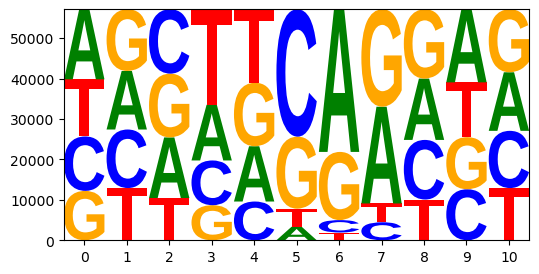

In [309]:
pat_logo = lm.Logo(counts_mat_pat, 
                   figsize=(6, 3),
                   font_name='Liberation Sans')
pat_logo.style_xticks()

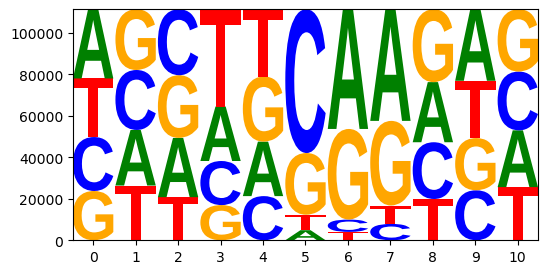

In [310]:
ben_logo = lm.Logo(counts_mat_ben, 
                   figsize=(6, 3),
                   font_name='Liberation Sans')
ben_logo.style_xticks()

Окрашивание по base_pairing:

In [279]:
# pat_logo = lm.Logo(counts_mat_pat, 
#                    figsize=(6, 3),
#                    color_scheme='base_pairing',
#                    font_name='Liberation Sans')
# pat_logo.style_xticks()

# ben_logo = lm.Logo(counts_mat_ben, 
#                    figsize=(6, 3),
#                    color_scheme='base_pairing',
#                    font_name='Liberation Sans')
# ben_logo.style_xticks()

Можно ещё по вероятностям строить:

In [69]:
# prob_mat_pat = lm.transform_matrix(counts_mat_pat, from_type='counts', to_type='probability')
# prob_mat_ben = lm.transform_matrix(counts_mat_ben, from_type='counts', to_type='probability')

#### Статистическое сравнение позиций в контекстах

Виды позиционных матриц:  

**Position Frequency Matrix (PFM)**:  
В ячейках PFM содержатся частоты каждого нуклеотида на соответствующей позиции в наборе последовательностей.
PFM не нормализуется по вероятностям, поэтому сумма значений в каждой строке может быть больше 1.  
  
**Position Probability Matrix (PPM)**:  
В отличие от PFM, значения в PPM нормализуются по вероятностям, так что сумма значений в каждой строке равна 1.
PPM показывает вероятность появления каждого нуклеотида на каждой позиции в последовательности.  

**Position Weight Matrix (PWM)**:  
Значения в PWM выражены в виде весов, которые показывают предпочтительность каждого нуклеотида на каждой позиции. Веса обычно вычисляются как логарифм отношения частоты наблюдения нуклеотида к ожидаемой частоте нуклеотида на данной позиции.

Для начала надо из списка контекстов создать Position Probability Matrix.

In [311]:
# Преобразование списка контекстов в массив нампай
sequences_array_pat = np.array(filtered_context_pat)
sequences_array_ben = np.array(filtered_context_ben)

# Можно удалить наны на этом шаге
# sequences_array = sequences_array[sequences_array != None]

# Создание пустого массива для хранения частот
freq_array_pat = np.zeros((len(sequences_array_pat[0]), 4))
freq_array_ben = np.zeros((len(sequences_array_ben[0]), 4))

# Вычисление частоты каждой буквы на каждой позиции
for i, seq in enumerate(sequences_array_pat):
    for j, nt in enumerate(seq):
        if nt == 'A':
            freq_array_pat[j][0] += 1
        elif nt == 'C':
            freq_array_pat[j][1] += 1
        elif nt == 'G':
            freq_array_pat[j][2] += 1
        elif nt == 'T':
            freq_array_pat[j][3] += 1


for i, seq in enumerate(sequences_array_ben):
    for j, nt in enumerate(seq):
        if nt == 'A':
            freq_array_ben[j][0] += 1
        elif nt == 'C':
            freq_array_ben[j][1] += 1
        elif nt == 'G':
            freq_array_ben[j][2] += 1
        elif nt == 'T':
            freq_array_ben[j][3] += 1

In [312]:
freq_array_pat

array([[17320., 13456., 12211., 14129.],
       [14478., 14474., 15249., 12915.],
       [14978., 15920., 15766., 10452.],
       [13775., 11064.,  8671., 23606.],
       [13666.,  9583., 15694., 18173.],
       [ 3335., 31496., 17817.,  4468.],
       [35267.,  3071., 16861.,  1917.],
       [23920.,  4457., 24097.,  4642.],
       [15159., 14742., 17142., 10073.],
       [18070., 12616., 12876., 13554.],
       [14479., 14149., 15578., 12910.]])

In [313]:
freq_array_ben

array([[33380., 26024., 23780., 28274.],
       [26818., 28927., 29301., 26412.],
       [28595., 31829., 30232., 20802.],
       [26283., 21273., 16976., 46926.],
       [26283., 21312., 31411., 32452.],
       [ 4856., 69366., 29772.,  7464.],
       [57743.,  5954., 43724.,  4037.],
       [53851.,  7903., 40842.,  8862.],
       [29003., 27389., 35150., 19916.],
       [34498., 24128., 25182., 27650.],
       [27386., 28357., 30056., 25659.]])

Считаем хи-квадраты для каждой позиции при сравнении двух матриц:

In [314]:
freq_array_pat.shape

(11, 4)

In [315]:
freq_array_pat.shape[0]

11

In [316]:
chi2_values = []
p_values = []

for i in range(freq_array_pat.shape[0]):
    
    # Таблица сопряженности для каждой текущей позиции (строки в массиве)
    contingency_table = np.array([freq_array_pat[i], freq_array_ben[i]])
    # Два пропуска, т.к. chi2_contingency возвращает statistic, pvalue, dof и expected_freq
    chi2, p_value, _, _ = chi2_contingency(contingency_table)

    chi2_values.append(chi2)
    p_values.append(p_value)

for i, (chi2, p_value) in enumerate(zip(chi2_values, p_values)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")

Position 0: Chi-square = 8.479729456199495, p-value = 0.037070927813094
Position 1: Chi-square = 52.48858180596595, p-value = 2.3565213928278063e-11
Position 2: Chi-square = 16.833198154233497, p-value = 0.0007648168511529371
Position 3: Chi-square = 11.613658353545754, p-value = 0.00883087759308895
Position 4: Chi-square = 213.5183641206763, p-value = 5.055381191799088e-46
Position 5: Chi-square = 824.6096677929688, p-value = 1.990103948382499e-178
Position 6: Chi-square = 1674.1907064937418, p-value = 0.0
Position 7: Chi-square = 668.1830265848415, p-value = 1.6631660762673641e-144
Position 8: Chi-square = 56.43812004441709, p-value = 3.3872287359468375e-12
Position 9: Chi-square = 27.020320660279463, p-value = 5.8298868805321964e-06
Position 10: Chi-square = 20.161179666241125, p-value = 0.0001571743422732844


Вот так было без участия Clinvar, деление только по AC и LOEUF:

#### **seqlogo**

https://pypi.org/project/seqlogo/

Можно ещё логотипы строить через библиотеку seqlogo. Но ей нужно подавать уже готовую матрицу (пример выше).

In [84]:
# ppm_pat = seqlogo.Ppm(freq_array_pat)
# ppm_ben = seqlogo.Ppm(freq_array_ben)

# seqlogo.seqlogo(ppm_pat, ic_scale = False, format = 'svg', size = 'medium')
# seqlogo.seqlogo(ppm_ben, ic_scale = False, format = 'svg', size = 'medium')

### Пересечение интервалов интересующих позиций

In [3]:
import pandas as pd
from os.path import join

In [29]:
DATA_PATH = "data_dir"
data = pd.read_table(join(DATA_PATH, "deduplicated.tsv"))
data.head()

,Chr,Position,rsID,Ref,Alt,Consequence,Canonical,Gene_symbol,Domains,LoF,LoF_flag,LoF_filter
0,chr18,46050,rs744323,C,T,"['ENST00000308911: downstream_gene_variant', '...","ENST00000308911: YES, ENST00000572530: YES, EN...","TUBB8B, LOC105371950",NaN,NaN,NaN,NaN
1,chr18,47239,.,TTTA,T,"['ENST00000308911: 3_prime_UTR_variant', 'ENST...","ENST00000308911: YES, ENST00000572530: YES, EN...","TUBB8B, LOC105371950",NaN,NaN,NaN,NaN
2,chr18,47242,rs893233952,A,G,"['ENST00000308911: 3_prime_UTR_variant', 'ENST...","ENST00000308911: YES, ENST00000572530: YES, EN...","TUBB8B, LOC105371950",NaN,NaN,NaN,NaN
3,chr18,47243,.,T,C,"['ENST00000308911: 3_prime_UTR_variant', 'ENST...","ENST00000308911: YES, ENST00000572530: YES, EN...","TUBB8B, LOC105371950",NaN,NaN,NaN,NaN
4,chr18,47245,.,A,T,"['ENST00000308911: 3_prime_UTR_variant', 'ENST...","ENST00000308911: YES, ENST00000572530: YES, EN...","TUBB8B, LOC105371950",NaN,NaN,NaN,NaN


In [7]:
data.shape

(339, 12)

Из распарсенной таблицы отобрали только строки, содержащие непустые значения в одном из лоф-полей (LoF/LoF_flag/LoF_filter)  

In [30]:
filtered_data = data[(~data['LoF'].isna()) | (~data['LoF_flag'].isna()) | (~data['LoF_filter'].isna())]

In [21]:
filtered_data.shape

(10, 12)

Перевели в vcf

In [32]:
vcf_df = filtered_data[['Chr', 'Position', 'rsID', 'Ref', 'Alt']] 
vcf_df.loc[:, 'QUAL'] = "."
vcf_df.loc[:, 'FILTER'] = "."
vcf_df.loc[:, 'INFO'] = "."

header = """##fileformat=VCFv4.2
#CHROM POS ID REF ALT QUAL FILTER INFO
"""

output_VCF = "data_dir/myfile.vcf"
with open(output_VCF, 'w') as vcf:
    vcf.write(header)

vcf_df.to_csv(output_VCF, sep="\t", mode='a', index=False, header=False)

/tmp/ipykernel_4995/4217350662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vcf_df.loc[:, 'QUAL'] = "."
/tmp/ipykernel_4995/4217350662.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vcf_df.loc[:, 'FILTER'] = "."
/tmp/ipykernel_4995/4217350662.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Сделала  
! bedtools intersect -wo -a myfile.vcf -b gencode.v45.annotation.gtf.gz > intersected_annotations.gtf

Получился файл intersected_annotations.gtf